In [ ]:
!pip install obci_readmanager

     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 6.2MB 17.9MB/s 
  Created wheel for mne: filename=mne-0.17.2-cp37-none-any.whl size=6194576 sha256=897e5d4fdcd2ff7c39ac30a0f18987b87907532d37f7f02e0c008b0c3d1066fe
  Stored in directory: /root/.cache/pip/wheels/e4/be/8b/6b737d272fb91d42e7ac5d61cc93227df7d71944e0e0eb15dd
Successfully built mne


In [ ]:
from obci_readmanager.signal_processing.read_manager import ReadManager as rm
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from obci_readmanager.signal_processing.smart_tags_manager import SmartTagsManager
from obci_readmanager.signal_processing.tags.smart_tag_definition import (
                    SmartTagDurationDefinition,
                    SmartTagEndTagDefinition)
import math
from math import floor, ceil

In [ ]:
xml = "/content/kasia_tw2.xml"
raw = "/content/kasia_tw2.raw"
tag = "/content/kasia_tw2.tag"
mgr = rm(xml,raw,tag)

sampling = float(mgr.get_param("sampling_frequency"))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

mgr_info = (sampling, num_of_channels, channels_names)
for i in mgr_info:
  print(i)

syg_raw = mgr.get_microvolt_samples()

2021-05-22 20:13:30,230 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


2048.0
5
['fr1', 'fr2', 'dp', 'or', 'TSS']


[-4653.43471724 -4656.00871736 -4655.22221732 ... -5706.84426641
 -5706.12926638 -5707.84526646]


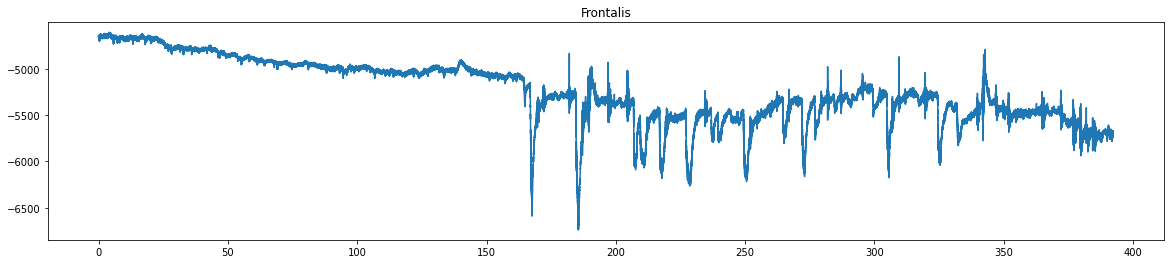

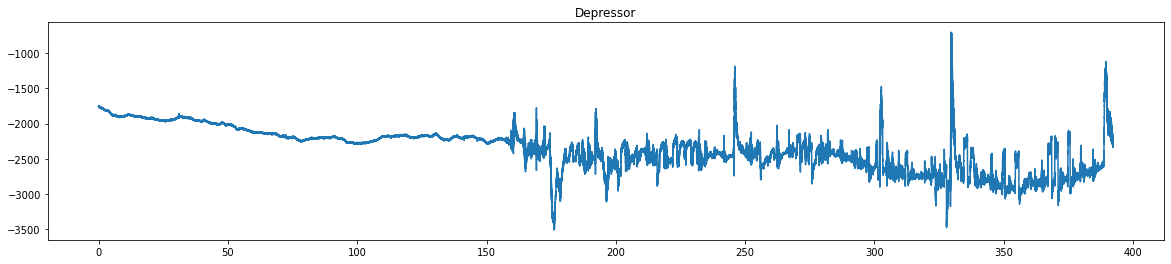

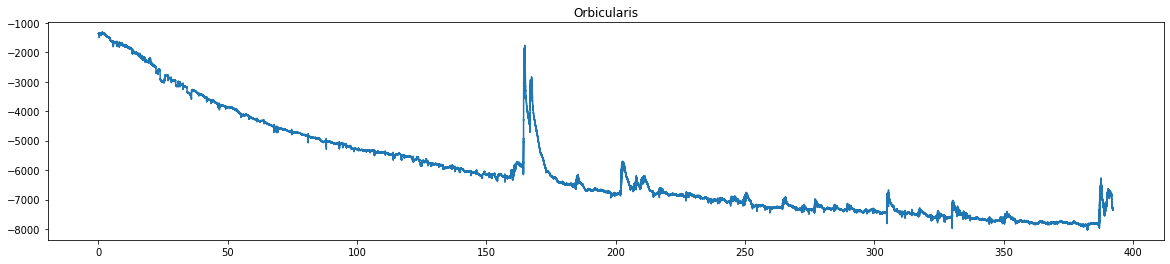

In [ ]:
signals = {
    'Frontalis': np.array(syg_raw[1]) - np.array(syg_raw[0]),
    'Depressor': np.array(syg_raw[2]),
    'Orbicularis': np.array(syg_raw[3]),
}

print(signals['Frontalis'])

for muscle in signals:
  plt.figure(figsize=(20,4))
  t = np.arange(0, len(signals[muscle])/2048, 1/2048)
  plt.plot(t, signals[muscle])
  plt.title(muscle)
  plt.show()

---
# Filtrowanie


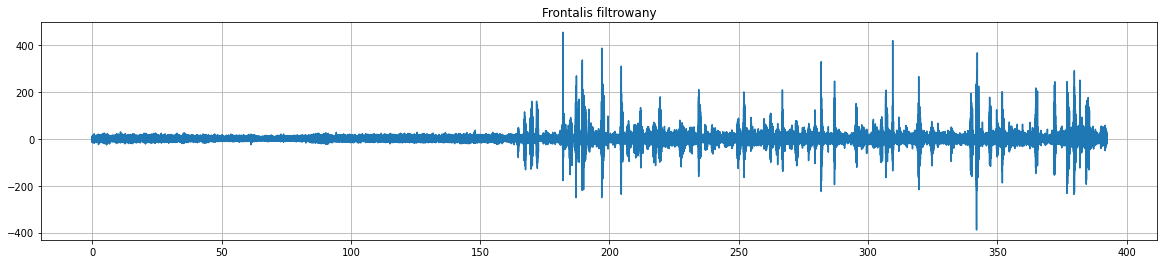

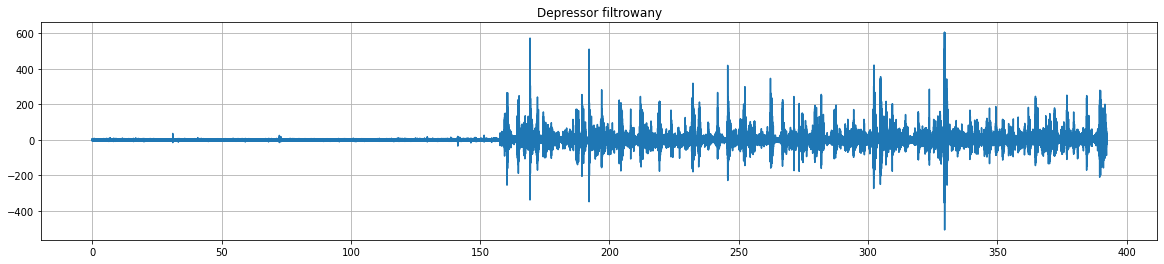

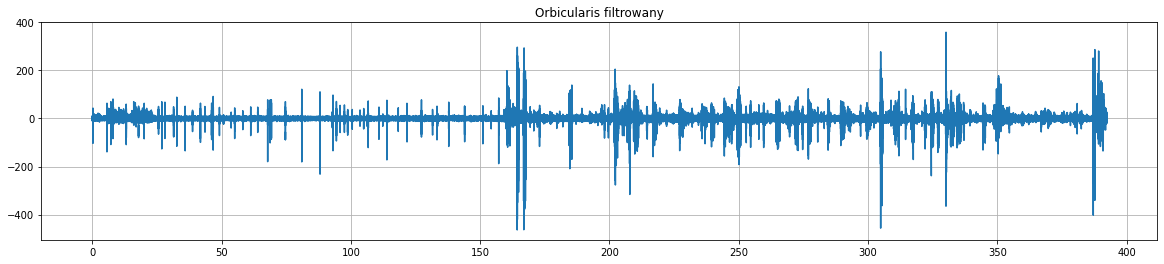

In [ ]:
a, b = signal.butter(3, 30, btype='highpass', fs=2048)
c, d  = signal.butter(3, 500, btype='lowpass', fs=2048)
e, f = signal.iirnotch(50/2048, 30, fs=2.0)

signals_filtered = {}
for muscle in signals:
  signals_filtered[muscle] = signal.filtfilt(a, b, signals[muscle], axis=0)
  signals_filtered[muscle] = signal.filtfilt(c, d, signals_filtered[muscle], axis=0)
  signals_filtered[muscle] = signal.filtfilt(e, f, signals_filtered[muscle], axis=0)

for muscle in signals_filtered:
  plt.figure(figsize=(20,4))
  t = np.arange(0, len(signals_filtered[muscle])/2048, 1/2048)
  plt.plot(t, signals_filtered[muscle])
  plt.grid()
  plt.title(muscle + ' filtrowany')
  plt.show()

# Kwadrat


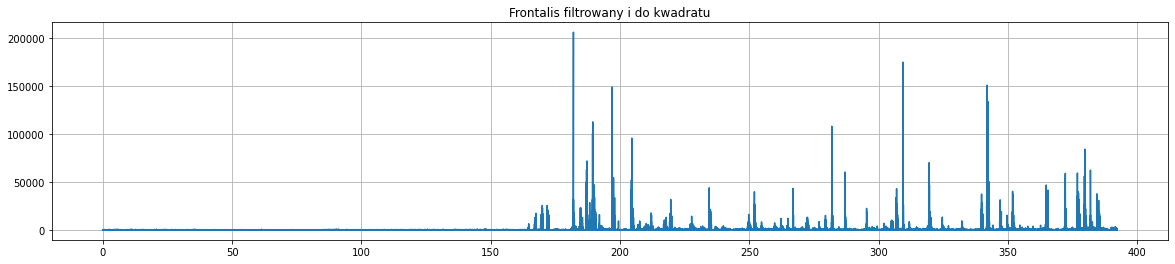

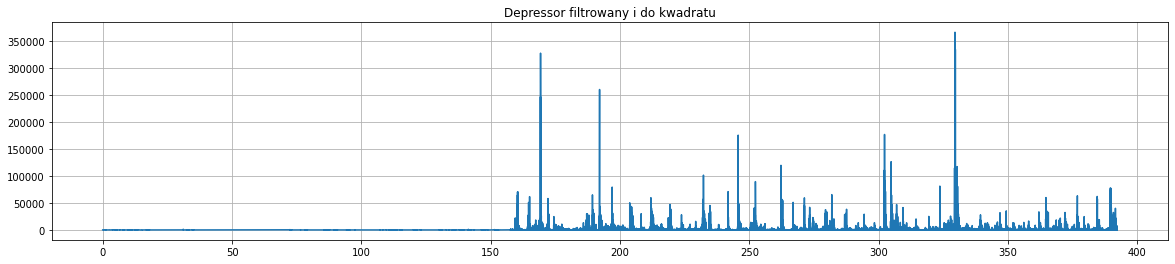

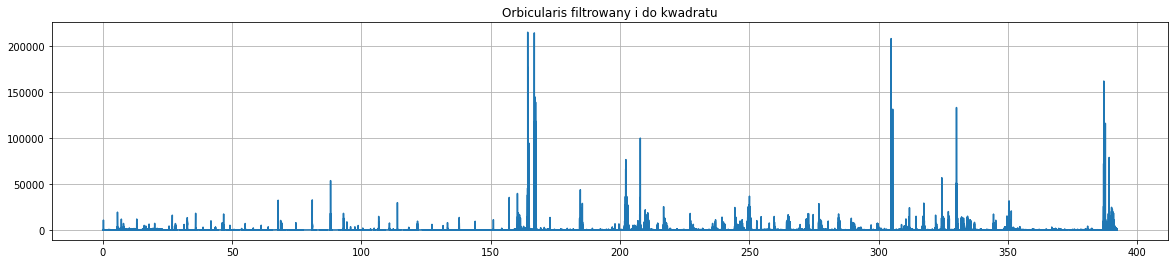

In [ ]:
signals_filtered_squared = {}

for muscle in signals_filtered:
  signals_filtered_squared[muscle] = signals_filtered[muscle]**2

for muscle in signals_filtered_squared:
  plt.figure(figsize=(20,4))
  t = np.arange(0, len(signals_filtered_squared[muscle])/2048, 1/2048)
  plt.plot(t, signals_filtered_squared[muscle])
  plt.grid()
  plt.title(muscle + ' filtrowany i do kwadratu')
  plt.show()

---
# Średnia biegnąca

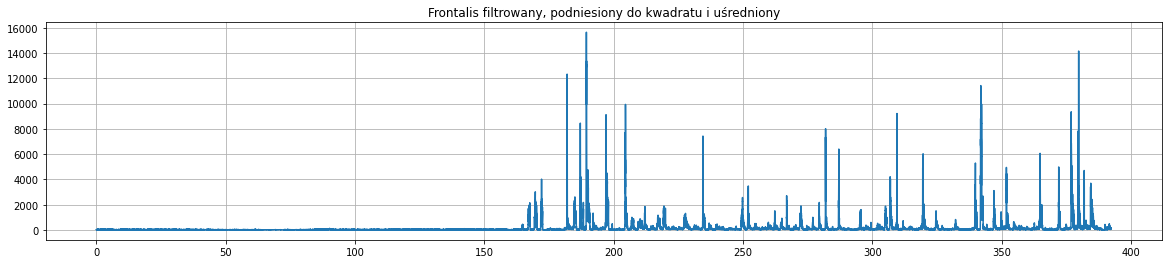

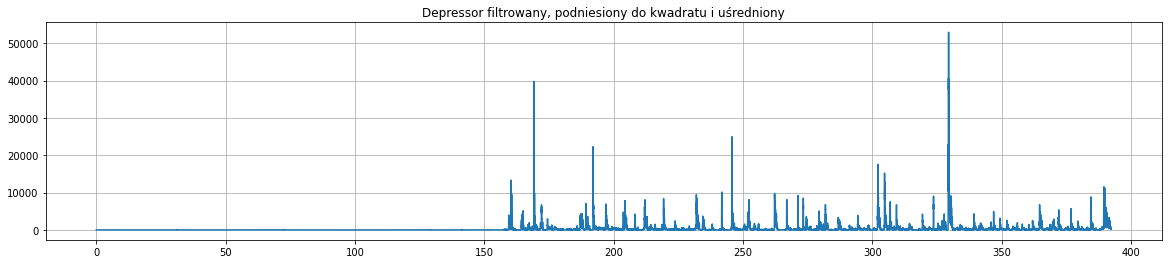

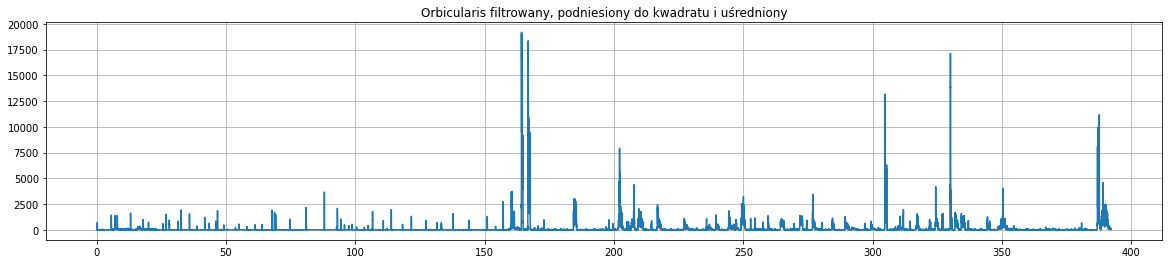

In [ ]:
signals_filtered_squared_windowed = {}
mean_len = 102

for muscle in signals_filtered:
  current = signals_filtered_squared[muscle]
  leng = len(current)
  placeholder = []
  for i in range(leng):
    if i+mean_len>leng:
      break
    else:
      sample = np.mean(current[i:i+mean_len])
      placeholder.append(sample)
  signals_filtered_squared_windowed[muscle] = placeholder

for muscle in signals_filtered:
  plt.figure(figsize=(20,4))
  plt.title(muscle+' filtrowany, podniesiony do kwadratu i uśredniony')
  plt.plot(np.arange(0, len(signals_filtered_squared_windowed[muscle])/sampling, 1/2048), np.array(signals_filtered_squared_windowed[muscle]))
  plt.grid()
  plt.show()

---
# Przydatne funkcje
Pobieranie tagów dla emocji i funkcja rysująca nałożone fragmenty

In [ ]:
def getTags(emotion):
  if emotion == 'sad':
    tags = (mgr.get_tags('01F_SA_C.bmp'), mgr.get_tags('02F_SA_C.bmp'))
  elif emotion == 'anger':
    tags = (mgr.get_tags('01f_an_c.bmp'), mgr.get_tags('02f_an_c.bmp'))
  elif emotion == 'surprise':
    tags = (mgr.get_tags('01F_SP_O.bmp'), mgr.get_tags('02F_SP_O.bmp'))
  else:
    print("Wrong input")
  
  st_temp = []
  et_temp = []

  for i in range(len(tags[0])):
    st_temp.append(tags[0][i]['start_timestamp'])
    et_temp.append(tags[0][i]['end_timestamp'])
  for i in range(len(tags[1])):
    st_temp.append(tags[1][i]['start_timestamp'])
    et_temp.append(tags[1][i]['end_timestamp'])

  st_temp.sort()
  et_temp.sort()

  tags = {
      'passive': {'st': st_temp[0:30], 'et': et_temp[0:30]},
      'active':  {'st': st_temp[30:60], 'et': et_temp[30:60]}
  }    

  return tags

In [ ]:
def drawEmotion(emotion, activity):
  tags = getTags(emotion)
  y = np.arange(0, 3, 1/2048)
  numer = 1
  fig = plt.figure(figsize=(30,5))
  current_mean = np.zeros(6144)

  fig.suptitle(activity+', '+emotion)
  for muscle in signals_filtered_squared_windowed:
    ax = fig.add_subplot(2, 3, numer)
    for i in range(len(tags[activity]['st'])):
      start = round(tags[activity]['st'][i],2)
      baseline = np.mean(signals_filtered_squared_windowed[muscle][int(start)*2048-2048 : int(start)*2048])
      x = np.array(signals_filtered_squared_windowed[muscle][int(start)*2048 : int(start)*2048+3*2048])-baseline
      x[x<0] = 0 # nie jestem pewien, czy powinienem to zerować dla ujemnych wartości, ale wydaje się to sensowne,
      # mamy tylko dodatnie wartości po kwadracie, więc ujemne pojawiające się po korekcie są trochę anomaliami, które nie powinny mieć miejsca
      ax.plot(y, x)
      current_mean += x/len(tags[activity]['st'])
    ax.grid()
    ax.title.set_text(muscle)
    ax = fig.add_subplot(2, 3, numer+3)
    ax.plot(y, current_mean)
    ax.legend(['mean'])
    numer += 1


  fig.show()



# Gniew
  Potencjalnie aktywne mięśnie: Orbicularis

  Wynik: Najwyższa szczytowa aktywność przy porównywaniu średnich mięśni

-


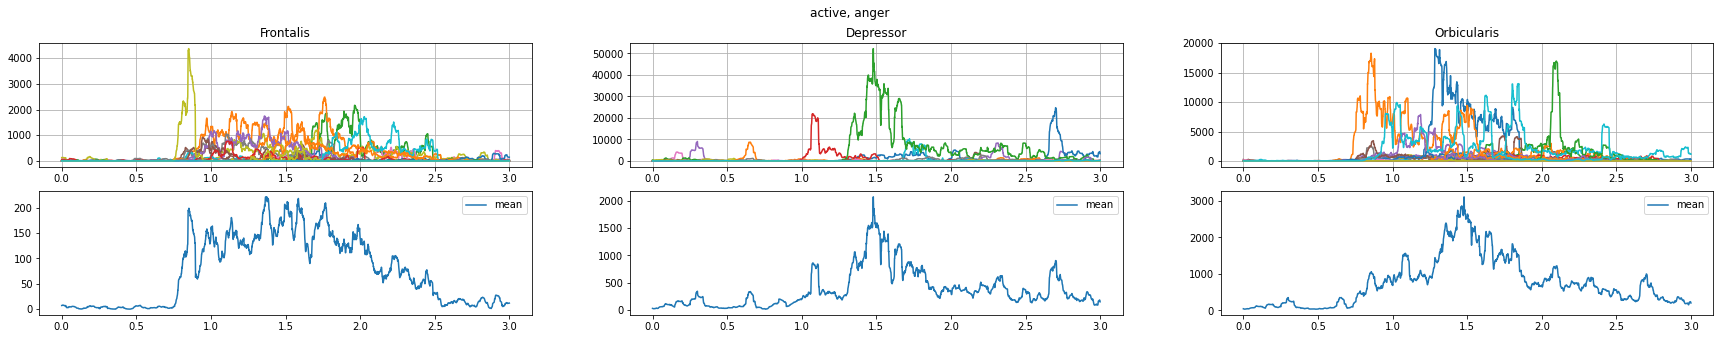

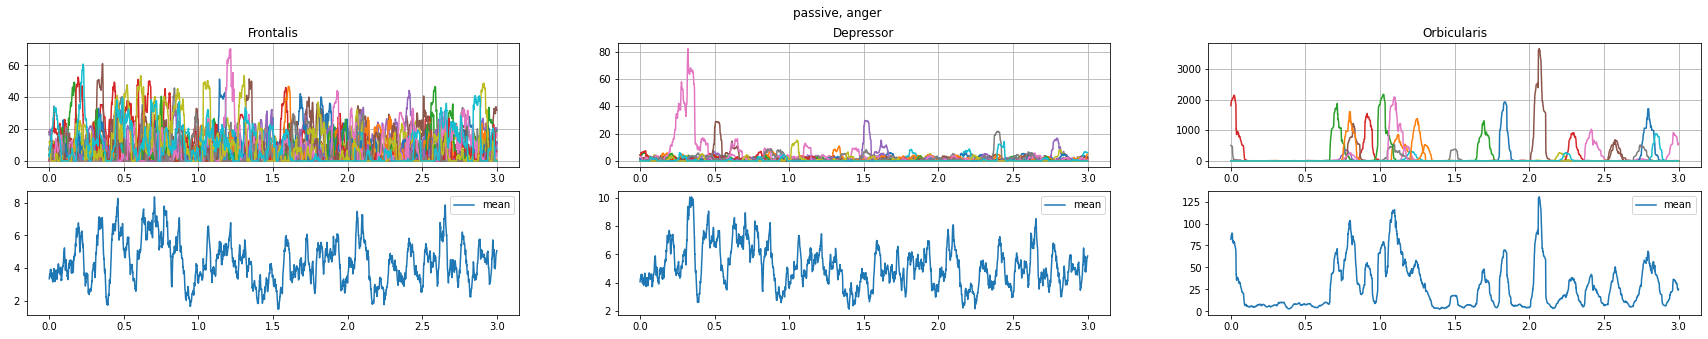

In [ ]:
drawEmotion('anger', 'active')
drawEmotion('anger', 'passive')

# Zdziwienia
Potencjalnie aktywne mięśnie: Frontalis

Wynik: Wzmożona aktywność wszystkich mięśni

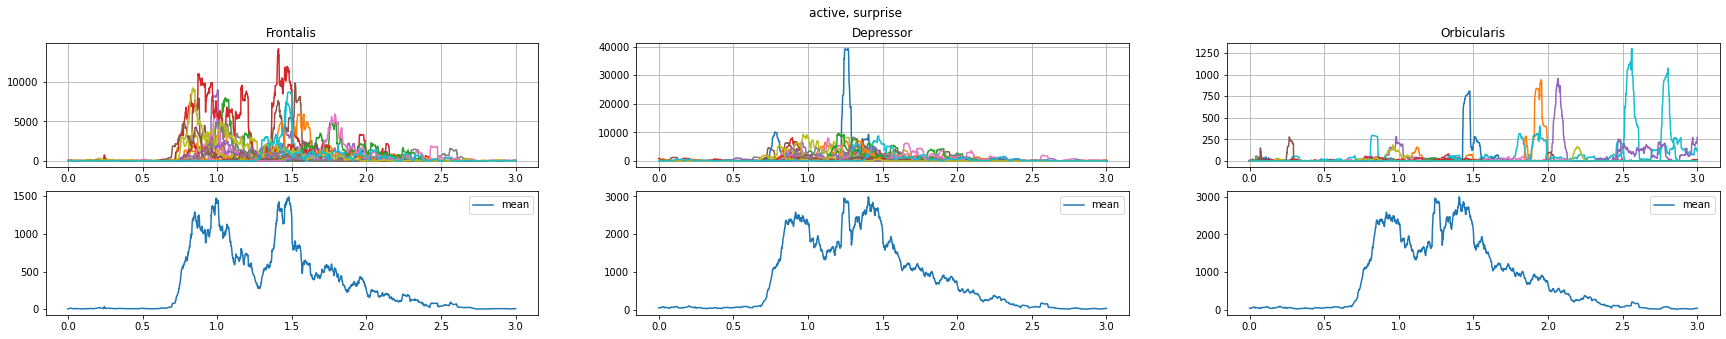

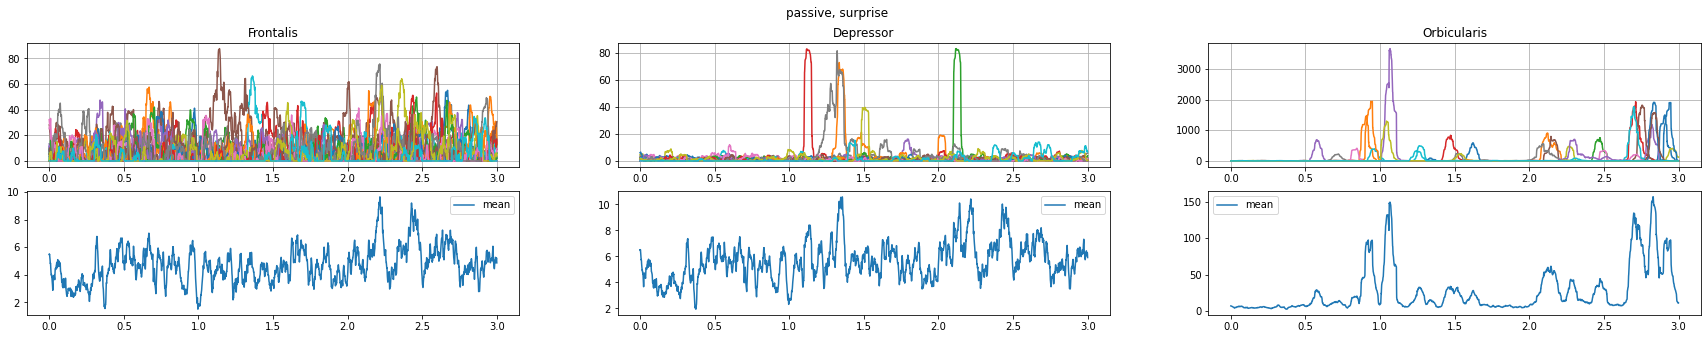

In [ ]:
drawEmotion('surprise', 'active')
drawEmotion('surprise', 'passive')

# Smutek
Potencjalnie aktywne mięśnie: Frontalis i Depressor

Wynik: Aktywność bardzo zbliżona do Orbicularisa

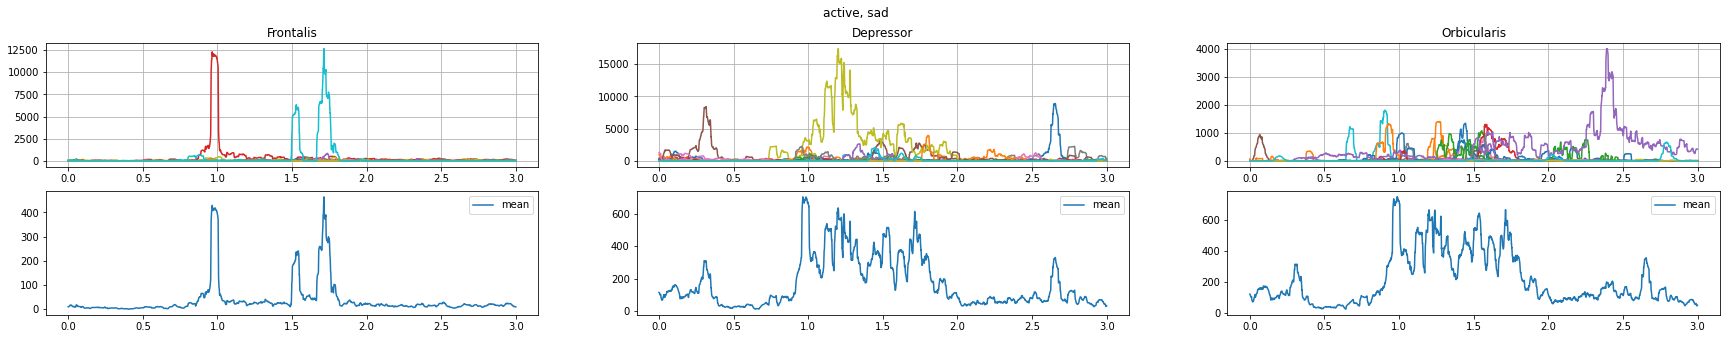

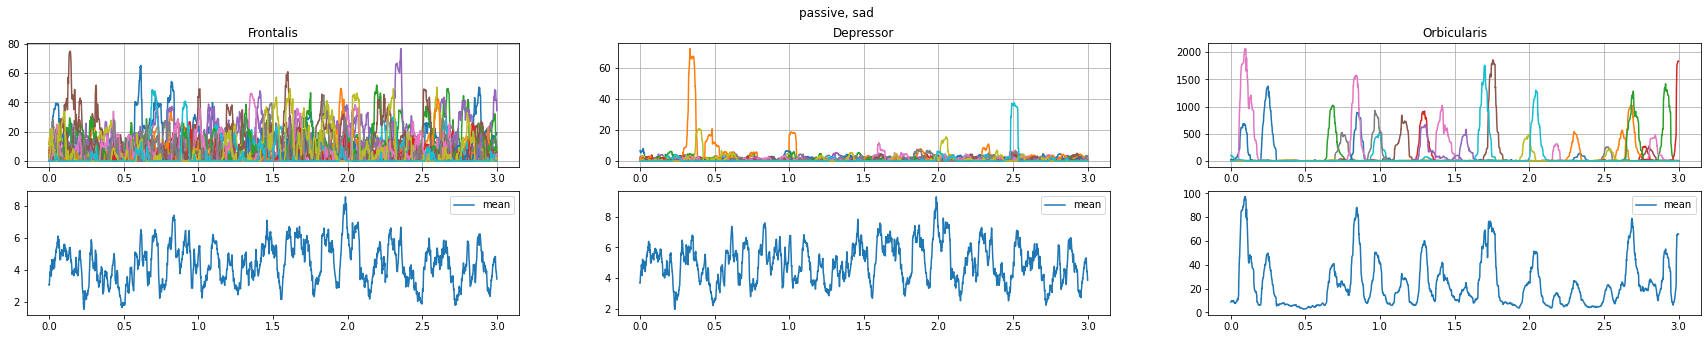

In [ ]:
drawEmotion('sad', 'active')
drawEmotion('sad', 'passive')